![](../images/header.png)

# DreamCatcher: Deep Learning and Graph Analytics for the Dreamscape <a class="anchor" id="top"></a>

April 2021 - Ana Areias - Kineviz Data Scientist

Dive into 30,000 dreams from [UCSC’s DreamBank](http://dreambank.net/) with Kineviz Data Scientist, Ana Areias. This post will walk you through using deep learning for NLP and text-to-image generation, GraphXR and Neo4j to build a dream similarity graph, identify and interpret dream clusters and visualize and explore the subconscious terrain.

Follow along below with step-by-step instructions on how to process the data, upload to a local Neo4j instance running on a Docker container and connect your GraphXR account.

While the choice of dreams data is a bit tongue-in-cheek, the methodology we use here can be applied in many other domains in order to make sense of large amounts of data, find hidden connections and create compelling visualizations.
 
This notebook is a companion to the [main blogpost with our dream visualizations](https://www.kineviz.com/post/2021/5/3/dreamcatcher-deep-learning-and-graph-analytics-for-the-dreamscape) and is divivided into two main parts:

* [1. Data processsing and preparation with deep learning and Neo4j](#part1)    
    * [1.1. Loading 30,000 dream reports](#loading)  
    * [1.2. Dream embeddings with doc2vec and building a Dream Similarity Graph](#doc2vec) 
    * [1.3. Extracting entities with spaCy](#spacy)  
    * [1.4. Load dreams into Neo4j database running on Docker](#neo4j)  
    * [1.5. Text to Image generation with Aleph2Image and Google colab](#colab)
    
    
* [2. Visualization, exploration and narrative with GraphXR](#part2)  
    * [2.1. Shared dreams across dreamers](#shared)  
    * [2.2. Dream interpretation](#interpret)   
    * [2.3. Dreams clusters](#clusters)  
    * [2.4. Adding dream snapshots](#snapshots)
    
    
    
   

## 1. Data processing and preparation with Deep Learning and Neo4j 

### 1.1. Loading 30,000 dream reports  <a class="anchor" id="loading"></a>

[Back to top](#top)

We pull almost 30,000 dream reports from [UCSC’s DreamBank](http://dreambank.net/) into Neo4j. 

Luckily, Matt Bierner scraped all dreams and made them available as json files in his github, which you can download directly.

In [ ]:
!git clone -q https://github.com/mattbierner/DreamScrape.git ../

We're going to transform these separate json files into one pandas dataframe.

In [59]:
import os 
import json
import pandas as pd
import numpy as np 

dreamers=os.listdir("../DreamScrape/dreams")
dreamers

['phil1.json',
 'phil2.json',
 'jasmine4.json',
 'seventh_graders.json',
 'jeff.json',
 'vonuslar.de.json',
 'pegasus.json',
 'jasmine3.json',
 'miami-home.json',
 'jasmine2.json',
 'madeline4-postgrad.json',
 'bosnak.json',
 'physiologist.json',
 'david.json',
 'ed.json',
 'peru-f.json',
 'wedding.json',
 'ringo.json',
 'vietnam_vet2.json',
 'zurich-f.de.json',
 'b2.json',
 'ucsc_women.json',
 'toby.json',
 'esther.json',
 'edna.json',
 'midwest_teens-m.json',
 'zurich-m.de.json',
 'bay_area_girls_789.json',
 'chris.json',
 'norms-m.json',
 'miami-lab.json',
 'mack.json',
 'german-f.de.json',
 'norms-f.json',
 'nancy.json',
 'melora.json',
 'madeline1-hs.json',
 'peru-m.json',
 'emma.json',
 'phil3.json',
 'norman.json',
 'bea2.json',
 'bea1.json',
 'madeline3-offcampus.json',
 'mark.json',
 'melissa.json',
 'tom.json',
 'kenneth.json',
 'german-m.de.json',
 'midwest_teens-f.json',
 'west_coast_teens.json',
 'jasmine1.json',
 'blind-f.json',
 'joan.json',
 'elizabeth.json',
 'madeline

In [60]:
df=pd.DataFrame()
for dr in dreamers:
    with open('../DreamScrape/dreams/'+dr) as json_file:
        jsn=json.load(json_file)
        d=pd.DataFrame(jsn['dreams'])
        d['dreamer']=jsn['dreamer']
        d['description']=jsn['description']
        df=df.append(d)

df.index=range(len(df)) 

In [62]:
df.head()

,number,head,content,dreamer,description
0,1-001,1957-08-05,Uncle Albert is getting ready to leave for a v...,phil1,Phil 1: teens
1,1-002,1957-08-06,I go to a ball game with Uncle Ben and Aunt Ai...,phil1,Phil 1: teens
2,1-003,1957-08-07,Rover (our dog) has to be shot. I am appointe...,phil1,Phil 1: teens
3,1-004,1957-08-08,We are in Grandpa's car. Grandpa is driving. ...,phil1,Phil 1: teens
4,1-005,1957-08-08,Something about Sue Henderson standing by some...,phil1,Phil 1: teens


Some dream journal entries are in German, and we can drop these.

In [63]:
drop=['vonuslar.de','zurich-f.de','zurich-m.de', 'german-f.de', 'german-m.de']
df=df.loc[~df['dreamer'].isin(drop)]

In [64]:
len(df)

22415

In [65]:
df.number.nunique()

9907

We add an unique ID to each dream for use later in Neo4j.

In [66]:
df['idx']=np.nan
for i, name in enumerate(list(df['dreamer'].unique())):
    df.loc[df['dreamer']==name, ['idx']] =  df.loc[df['dreamer']==name]['number'].apply(lambda x: str(i)+"-"+x)

We have 22,415 dreams from 69 unique dreamers to work with.

In [67]:
df.idx.nunique()

22415

In [68]:
df.dreamer.nunique()

69

## 2. Dream embeddings and building a Dream Similarity Graph <a class="anchor" id="doc2vec"></a>

[Back to top](#top)


To start with, we capture the vector representation of each dream using a Gensim Doc2Vec model trained on the dream content. We gauge how similar two dreams are by their cosine similarity.

We preprocess the data by removing stop words and tokenizing.


In [8]:
import gensim
from gensim.parsing.preprocessing import remove_stopwords

In [9]:
def preprocess(df):
    for row in df.iterrows():
        filtered=remove_stopwords(row[1]['content'])
        tokens = gensim.utils.simple_preprocess(filtered)
        yield gensim.models.doc2vec.TaggedDocument(tokens, [row[0]])

This is what the first dream looks like once pre-processed.

In [10]:
list(preprocess(df.loc[:0,]))

[TaggedDocument(words=['uncle', 'albert', 'getting', 'ready', 'leave', 'vacation', 'taking', 'along', 'don', 'want', 'go', 'tell', 'uncle', 'albert', 'coming', 'makes', 'difference', 'someone', 'finally', 'come', 'me', 'though', 'uncle', 'joe', 'on', 'way', 'home', 'or', 'going', 'stop', 'old', 'school', 'storey', 'summer', 'school', 'going', 'on', 'tell', 'pat', 'byers', 'goodbye', 'there', 'rooms', 'floor', 'door', 'look', 'one', 'everyone', 'apparently', 'having', 'lot', 'fun', 'when', 'spotted', 'trouble', 'class', 'explain', 'don', 'school', 'come', 'tell', 'goodbye', 'beginning', 'think', 'won', 'head', 'th', 'room', 'upstairs', 'tell', 'goodbye', 'don', 'remember', 'how', 'by', 'time', 'outside', 'dusk', 'dark', 'wait', 'dark', 'uncle', 'joe', 'look', 'building', 'etc', 'can', 'him', 'growing', 'worried'], tags=[0])]

Preprocessing the entire dataframe:

In [11]:
train_corpus=list(preprocess(df))

The preprocessed data is then fed into a doc2vec model with the default parameters.

In [12]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=55, min_count=10, epochs=40)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [13]:
model.save("dreams-doc2vec-model")

We build a function to get index position and the similarity score for the n most similar dreams.

In [14]:
def get_most_similar(text,n=3):
    filtered=remove_stopwords(text)
    tokens = gensim.utils.simple_preprocess(filtered)
    vector = model.infer_vector(tokens)
    sims = model.docvecs.most_similar([vector]) 
    return [i for i in sims[:n]]

You can see that in this case, the most similar dream to dream at index position 0 is itself with score 0.96, so from now on we discard the most similar dream.

In [17]:
get_most_similar(df['content'][0],10)


[(0, 0.9645031690597534),
 (24678, 0.53974449634552),
 (28, 0.5249481797218323),
 (20560, 0.5181839466094971),
 (17754, 0.5164690017700195),
 (2204, 0.513573169708252),
 (26535, 0.503899335861206),
 (14, 0.5036380887031555),
 (1200, 0.4850434362888336),
 (23335, 0.4808422029018402)]

For each dream, let's add the indices and scores for the 9 most similar dreams to it.

In [18]:
df['neighbors']=df['content'].apply(lambda x: get_most_similar(x,n=10)[1:])

Let's take a look at the distribution of similarity scores so that we can decide which threshold to use to connect our dreams in our dream similarity graph.

In [19]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

For the second most similar dreams, most scores are above 0.6.

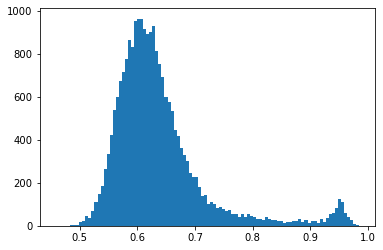

In [21]:
matplotlib.pyplot.hist([x[0][1] for x in df['neighbors']], bins=100)
plt.show()

In the case of the 9th most similar dream, most scores are below 0.6. So let's use 0.6 as the threshold above which we will connect two dreams in our dream similarity graph.

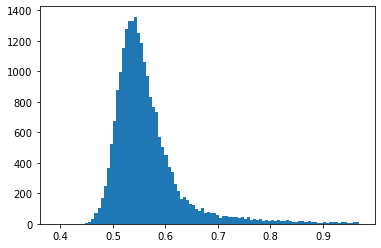

In [22]:
matplotlib.pyplot.hist([x[8][1] for x in df['neighbors']], bins=100)
plt.show()

In [24]:
df.to_csv("../data/dreams-neighbors.csv", index=False)

## 3. Extracting entities with spaCy <a class="anchor" id="spacy"></a>

[Back to top](#top)


[spaCy](https://spacy.io/api/entityrecognizer) allows us to load a pre-trained model in order to identify 

> a variety of named and numeric entities, including companies, locations, organizations and products.


For each dream journal entry below we see what entities spaCy picks out.


In [36]:
import spacy 
nlp = spacy.load("en_core_web_sm")


In [ ]:
mylist=[]
for idx, row in df.iterrows():
    doc=nlp(row['content'])
    if doc.ents:
        for ent in doc.ents:
            mylist.append((ent.text,ent.label_,row['idx']))

In [ ]:
ent_df=pd.DataFrame(mylist)
ent_df.columns=['text', 'entity_type','idx']


In [ ]:
g=ent_df.groupby(['text','entity_type','idx'])['idx'].count()
g=g.reset_index(level='entity_type')
g.columns=['entity_type','count']
g=g.reset_index()

In [9]:
g=pd.read_csv("../data/dream-entities.csv")

In [10]:
len(g)

79231

In [11]:
g.head(10)

,text,idx,entity_type,count
0,""" - Tree",59-362,WORK_OF_ART,1
1,""" George of Seinfeld",17-3274,WORK_OF_ART,1
2,"""Ba Ba",42-497,PERSON,1
3,"""Burning The House Down",42-1669,WORK_OF_ART,1
4,"""Can You Feel the Love Tonight",8-B-128,WORK_OF_ART,1
5,"""Can we take the ferry across?",33-1985-056,WORK_OF_ART,1
6,"""Come Go With Me",0-1-018,WORK_OF_ART,1
7,"""Crossing Delancy",54-1589,WORK_OF_ART,1
8,"""Crunch Something",62-222,WORK_OF_ART,1
9,"""Emily Combusted",36-055,WORK_OF_ART,1


In [12]:
g.entity_type.value_counts()

PERSON         23793
CARDINAL       18641
ORG             7198
DATE            6841
GPE             5073
ORDINAL         4383
TIME            4314
NORP            2200
QUANTITY        1560
MONEY           1394
FAC             1085
LOC              920
WORK_OF_ART      908
PRODUCT          355
LANGUAGE         306
EVENT            155
PERCENT           60
LAW               45
Name: entity_type, dtype: int64

## 4. Load dreams into Neo4j database running on Docker <a class="anchor" id="neo4j"></a>

[Back to top](#top)


Follow these instructions to [start a local Neo4j database instance in Docker.](https://neo4j.com/developer/docker-run-neo4j/)

For example, this is a simple bash script start-neo4j-container.sh that spins up a Neo4j container, mounts the requisite folders with the data and installs apoc and Graph Data Science libraries.




```bash 
#!/bin/sh

docker run \
	-u `id -u $USER` \
	--publish=7473:7473 \
	--publish=7474:7474 \
	--publish=7687:7687 \
	--rm \
	--volume=/home/areias/Documents/kineviz/dreams/data:/data \
	--volume=/home/areias/Documents/kineviz/dreams/plugins:/plugins \
    --volume=/home/areias/Documents/kineviz/dreams/import:/var/lib/neo4j/import  \
	--env NEO4J_AUTH=neo4j/test \
    -e NEO4J_apoc_export_file_enabled=true \
    -e NEO4J_apoc_import_file_enabled=true \
    -e NEO4J_apoc_import_file_use__neo4j__config=true \
    -e NEO4JLABS_PLUGINS='["apoc", "graph-data-science"]' \
	--name neo4j \
	  neo4j \
```

Then we can upload the data into Neo4j via Python.

In [4]:
from py2neo import  Graph, Node


In [3]:
# connecting to neo4j db
graphdb = Graph(scheme="bolt", host="localhost", port=7687, secure=False, 
                auth=('neo4j', 'test'))
#graphdb.delete_all(), useful in case you want to start over


### Create constraints

In [7]:
# creating constraints
query="""CREATE CONSTRAINT ON (d:Dreamer) ASSERT d.name IS UNIQUE"""
graphdb.run(query)

In [8]:
query="""CREATE CONSTRAINT ON (d:Dream) ASSERT d.idx IS UNIQUE"""
graphdb.run(query)

In [9]:
query="""CREATE CONSTRAINT ON (d:Entity) ASSERT d.id IS UNIQUE"""
graphdb.run(query)

### Loading Dreamer nodes

In [10]:
df=pd.read_csv("../data/dreams-neighbors.csv")

In [11]:
# Dreamer nodes
d=df[['dreamer','description']]
d=d.drop_duplicates()
d.head()

,dreamer,description
0,phil1,Phil 1: teens
106,phil2,Phil 2: late 20s
326,jasmine4,Jasmine 4: college 2
420,seventh_graders,Seventh grade girls
489,jeff,Jeff: a lucid dreamer


In [12]:
len(d)

69

In [13]:
dreamers=[{"name": x[1]['dreamer'],
 "description": x[1]['description']} for x in d.iterrows()]

In [14]:
dreamers[0:5]

[{'name': 'phil1', 'description': 'Phil 1: teens'},
 {'name': 'phil2', 'description': 'Phil 2: late 20s'},
 {'name': 'jasmine4', 'description': 'Jasmine 4: college 2'},
 {'name': 'seventh_graders', 'description': 'Seventh grade girls'},
 {'name': 'jeff', 'description': 'Jeff: a lucid dreamer'}]

In [15]:
query = """
    UNWIND $dreamers AS dreamer
    MERGE (d:Dreamer {name: dreamer.name, description: dreamer.description})"""
graphdb.run(query, {"dreamers":dreamers})

### Creating Dream nodes and connecting them to Dreamers with the DREAMT_BY relationship

In [16]:
dreams=[{"dreamer": x[1]['dreamer'],
         "content": x[1]['content'],
        "date": x[1]['head'] ,
        "number": x[1]['number'],
        "idx":x[1]['idx']} for x in df.iterrows()]

In [17]:
dreams[0:2]

[{'dreamer': 'phil1',
  'content': "Uncle Albert is getting ready to leave for a vacation and is taking me along.  I don't want to go, and I tell Uncle Albert that someone is coming by to get me at 11:00 a.m., but it makes no difference.  Someone does finally come by for me, though:  Uncle Joe.  On the way home (or wherever we are going), we stop at an old school (2-storey) where summer school is going on.  I am to tell Pat Byers goodbye.  There are about 8 rooms on each floor.  I go to the door and look in each one.  Everyone is apparently having a lot of fun.  When I am spotted, I get in trouble for being out of class, but I explain that I don't go to school there and I have come to tell someone goodbye.  I am beginning to think that I won't find her when I see the back of her head, in the 16th room upstairs.  I tell her goodbye-I don't remember how..  By the time I go back outside, it is dusk, and almost dark.  I wait until dark for Uncle Joe, look around the building, etc., but can

In [18]:
query = """
    UNWIND $dreams AS dream
    MERGE (d:Dream {content: dream.content,
        date: dream.date,
        number: dream.number,
        dreamer: dream.dreamer,
        idx: dream.idx})
    MERGE (dr:Dreamer {name: dream.dreamer})
    MERGE (d)-[:DREAMT_BY]->(dr)
        """
graphdb.run(query, {"dreams":dreams})

### Joining similiar dreams with the MOST_SIMILAR relationship

Connecting all dreams with similarity score above 0.6.

In [19]:
similar=[]
for row in df.iterrows():
    origin=row[1]['idx']
    neighbors=eval(row[1]['neighbors'])
    similar+=[(origin, df.iloc[n[0]]['idx'],n[1]) for n in neighbors if n[1]>0.6]

In [20]:
len(similar)

62683

In [46]:
similar[0:5]

[('0-1-004', '48-1071', 0.6237183809280396),
 ('0-1-005', '48-0105', 0.7950225472450256),
 ('0-1-005', '54-1268', 0.7905269265174866),
 ('0-1-005', '38-0371', 0.7870646119117737),
 ('0-1-005', '35-257', 0.7848039865493774)]

In [47]:
r=[{"origin":x[0],
 "target":x[1],
 "weight":x[2] } for x in similar]

In [52]:
query = """
    UNWIND $dreams AS dream
    MERGE (d:Dream {idx: dream.origin})
    MERGE (d2:Dream {idx: dream.target})
    MERGE (d)-[m:MOST_SIMILAR]->(d2)
        SET m.similarity=dream.weight 
    """
graphdb.run(query, {"dreams":r})

### Loading Named Entity nodes

In [25]:
df=pd.read_csv("../data/dream-entities.csv")


In [26]:
len(df)

79231

In [27]:
df.head()

,text,idx,entity_type,count
0,""" - Tree",59-362,WORK_OF_ART,1
1,""" George of Seinfeld",17-3274,WORK_OF_ART,1
2,"""Ba Ba",42-497,PERSON,1
3,"""Burning The House Down",42-1669,WORK_OF_ART,1
4,"""Can You Feel the Love Tonight",8-B-128,WORK_OF_ART,1


In [28]:
e=df.loc[:,['text','entity_type']]
e=e.drop_duplicates()

In [29]:
len(e)

20936

In [30]:
e['id']=range(len(e))

In [31]:
e.head()

,text,entity_type,id
0,""" - Tree",WORK_OF_ART,0
1,""" George of Seinfeld",WORK_OF_ART,1
2,"""Ba Ba",PERSON,2
3,"""Burning The House Down",WORK_OF_ART,3
4,"""Can You Feel the Love Tonight",WORK_OF_ART,4


In [32]:
entities=[{"entity": x[1]['text'],
         "type": x[1]['entity_type'],
        "id": x[1]['id']} for x in e.iterrows()]

In [33]:
entities[0:5]

[{'entity': '" - Tree', 'type': 'WORK_OF_ART', 'id': 0},
 {'entity': '" George of Seinfeld', 'type': 'WORK_OF_ART', 'id': 1},
 {'entity': '"Ba Ba', 'type': 'PERSON', 'id': 2},
 {'entity': '"Burning The House Down', 'type': 'WORK_OF_ART', 'id': 3},
 {'entity': '"Can You Feel the Love Tonight', 'type': 'WORK_OF_ART', 'id': 4}]

In [34]:
query = """
    UNWIND $entities AS ent
    MERGE (e:Entity {text: ent.entity, type: ent.type, id: ent.id})"""
graphdb.run(query, {"entities":entities})

In [35]:
len(df)

79231

### Connecting Dreams and their Entities with the HAS_ENTITY relationship

In [36]:
df=pd.merge(df,e,on=['text','entity_type'],how="left")

In [37]:
df.head()

,text,idx,entity_type,count,id
0,""" - Tree",59-362,WORK_OF_ART,1,0
1,""" George of Seinfeld",17-3274,WORK_OF_ART,1,1
2,"""Ba Ba",42-497,PERSON,1,2
3,"""Burning The House Down",42-1669,WORK_OF_ART,1,3
4,"""Can You Feel the Love Tonight",8-B-128,WORK_OF_ART,1,4


In [38]:
entities=[{"idx": x[1]['idx'],
         "id": x[1]['id']} for x in df.iterrows()]

In [39]:
entities[0:5]

[{'idx': '59-362', 'id': 0},
 {'idx': '17-3274', 'id': 1},
 {'idx': '42-497', 'id': 2},
 {'idx': '42-1669', 'id': 3},
 {'idx': '8-B-128', 'id': 4}]

In [41]:
len(entities)

79231

In [40]:
query="""
    UNWIND $entities AS ent
    MERGE (e:Entity {id: ent.id})
    MERGE (d:Dream {idx: ent.idx})
    MERGE (d)-[:HAS_ENTITY]->(e)
    """
graphdb.run(query, {"entities":entities})

Now we have the following schema set up on Neo4j:

![](../images/schema.png)

### 1.5. Text-to-Image generation with Aleph2Image and Google Colaboratory <a class="anchor" id="colab"></a>

[Back to top](#top)

Finally, for each dream we want to create an image related to the dream content. 

For this we use Aleph2Image Delta pytorch model, available as a [Google Colaboratory notebook](https://colab.research.google.com/drive/1oA1fZP7N1uPBxwbGIvOEXbTsq2ORa9vb?usp=sharing#scrollTo=2aDcCMUnjQLh) developed by tech artist [@advadnoun](https://twitter.com/advadnoun) on Twitter.

Google Colaboratory allows you to use a free GPU instance to run the Pytorch model and generate images based on a text prompt. We use the first sentence of a dream journal entry. 

Host your resulting images on Github so we can link to them in GraphXR and make them part of the dreamscape as we detail in section 2.4.



A couple of my favourites images are this one based dreamer Chuck's dream from 1992.

> I am reading about a new type of professional soccer league in a color weekly news magazine. There is a description of the game and some of the new teams, including a team named the "Cosmos", which the magazine article says may follow in a "tradition of dynasty by previous teams of the same name in earlier leagues." I find myself at the opening game playing for the "Cosmos". The rules are a bit changed from regular soccer: a center square portion of the field is quite a bit raised in elevation over the rest (i.e., it is not a level playing field.) This center portion is landscaped with bushes and trees, and the rest of the field, which looks like a standard field, is reached by steep ramps. Play begins at the center of the square section. The ball makes its way towards the goal of the opponents of the "Cosmos". I am standing there, and when the ball is nearby I kick it to the goal. I watch almost as if in slow-motion as the opponents' goal-keeper misses. I have scored a goal and everyone in the crowd cheers! Play resumes. I see that several players use their hands in this version of soccer, but I am not sure when this is allowed, so I decide to play as if it were regular soccer. Again I am standing near the opposing goal as the ball comes. I break out of a pack of players to get to the ball and from the right wing position I kick it into the goal. The poor opposing goalkeeper looks overwhelmed as the score goes by him. In an apparently new rule, after the goal is scored the goalkeeper himself kicks out the ball into play (instead of starting at the center of the field.) The opposing team plays sloppily and I quickly get possession of the ball again. I boot it hard directly at the goal and score a third time. The crowd goes wild as I exclaim, "I LOVE this game!" I turn to my brother X., who is one of my "Cosmos" teammates, and confide to him, "Their goalie is not too good; they should get another one."


![](../images/dreams/im_d52-31_100.png)

And another based in the following dream journal entry by Phil2 from 1971.

>  I was in a football stadium with my daughter Christina.  We kept climbing higher and higher, sometimes up steps with no railings, and I was always afraid Christina would fall, so I held her hand tightly.  At the top, apparently, was a wide grassy area where Johnny Unitas was warming up with another player, throwing a football back and forth.  I wondered if Unitas had been traded, because it seemed that Baltimore was not one of the teams playing that day.  Once, the ball they were throwing got away and bounced over to me.  I was still holding on to Christina, afraid to let go, so I couldn't field it as smoothly as I wanted to.  And when I tried to throw it back, wanting very badly to throw an impressive pass, I couldn't get a good grip on the ball (even though it was very much under inflated), and it slipped out of my hand when I threw it.  I was surprised, therefore, when one of the guys threw me two different balls later on, and I threw good, sharp spirals back to him.  The stadium may have been -- probably was -- my alma mater's stadium, especially because of the flat grassy area above one end zone grandstand.

![](../images/dreams/im_d1-2-116_100.png)

In [54]:
# ALeph2Image generated images pushed to github
files=os.listdir("../images/dreams")
files

['im_d25-0425_100.png',
 'im_d26-Mac-R-2_100.png',
 'im_d32-M15-2_100.png',
 'im_d28-0133_100.png',
 'im_d42-082_100.png',
 'im_d34-3-166_100.png',
 'im_d34-3-074_100.png',
 'im_d1-2-220_100.png',
 'im_d63-219-03_100.png',
 'im_d1-2-120_100.png',
 'im_d1-2-159_100.png',
 'im_d0-1-067_100.png',
 'im_d34-3-180_100.png',
 'im_d1-2-011_100.png',
 'im_d1-2-048_100.png',
 'im_d42-969_100.png',
 'im_d1-2-116_100.png',
 'im_d42-1638_100.png',
 'im_d52-31_100.png',
 'im_d1-2-084_100.png',
 'im_d66-0357_100.png']

In [55]:
# generating github urls
urls=[{"idx":x.split("_")[1],
 "im_url": "https://raw.githubusercontent.com/areias/dreams/master/images/dreams/"+x} for x in files]
urls

[{'idx': 'd25-0425',
  'im_url': 'https://raw.githubusercontent.com/areias/dreams/master/images/dreams/im_d25-0425_100.png'},
 {'idx': 'd26-Mac-R-2',
  'im_url': 'https://raw.githubusercontent.com/areias/dreams/master/images/dreams/im_d26-Mac-R-2_100.png'},
 {'idx': 'd32-M15-2',
  'im_url': 'https://raw.githubusercontent.com/areias/dreams/master/images/dreams/im_d32-M15-2_100.png'},
 {'idx': 'd28-0133',
  'im_url': 'https://raw.githubusercontent.com/areias/dreams/master/images/dreams/im_d28-0133_100.png'},
 {'idx': 'd42-082',
  'im_url': 'https://raw.githubusercontent.com/areias/dreams/master/images/dreams/im_d42-082_100.png'},
 {'idx': 'd34-3-166',
  'im_url': 'https://raw.githubusercontent.com/areias/dreams/master/images/dreams/im_d34-3-166_100.png'},
 {'idx': 'd34-3-074',
  'im_url': 'https://raw.githubusercontent.com/areias/dreams/master/images/dreams/im_d34-3-074_100.png'},
 {'idx': 'd1-2-220',
  'im_url': 'https://raw.githubusercontent.com/areias/dreams/master/images/dreams/im_d1

In [57]:
# uploading the img_url property
query="""
    UNWIND $urls as url
    MATCH (d:Dream) where d.idx = url.idx
    SET d.im_url = url.im_url """
graphdb.run(query, {'urls':urls})

## 2. Visualization and exploration with GraphXR <a class="anchor" id="part2"></a>

[Back to top](#top)

In this section you can find step-by-step instructions on how to create the visualizations we shared in the main blogpost.

First, [sign up to use GraphXR.](https://helpcenter.kineviz.com/user-guides/Working%20version/Logging-In-and-Out-of-GraphXR.985825405.html)

Then [create a project and connect it to your local Neo4j instance](https://helpcenter.kineviz.com/user-guides/Working%20version/Introducing-GraphXR-Projects.1042743346.html#IntroducingGraphXRProjects-CreateaprojectconnectedtoaNeo4jdatabase) running on Docker. If you choose a "GraphXR server connection" this will enable you to share graph views with others. Make sure you only use non-proprietary data if you use this type of connection.

Open your project, which will be empty to begin with. [Here are some tips to help you get quickly aquainted with the GraphXR project space.](https://helpcenter.kineviz.com/user-guides/Working%20version/Working-in-the-Project-Space.985825420.html)


## 2.1. Shared dreams across dreamers  <a class="anchor" id="shared"></a>
[Back to top](#top)

For our first view, we can choose a dreamer and see what dreams they share with others.

Open the [project panel in the main menu](https://helpcenter.kineviz.com/user-guides/Working%20version/Working-in-the-Project-Space.985825420.html#WorkingintheProjectSpace-Mainmenu) on the left edge of the graph space. It will look like this:


![](../images/project-panel.png)

* From the project panel, **Pull** some dreamer nodes, this brings up 25 dreamer nodes at a time.

* [**Select**](https://helpcenter.kineviz.com/user-guides/Working%20version/Selecting-Graph-Data.1073087182.html) the dreamer of interest, using **inverse** and **delete** from the **context toolbar** on the lower edged of the graph space, we can delete all other dreamer nodes and be left with the one we would like to analyse.

The context toolbar looks like this:

![](../images/context-toolbar.png)

* **Select** the dreamer node and select **Expand** from the context toolbar. This will bring up the Expand Relationships menu, choose the DREAMT_BY relationship to bring up that dreamer's dreams.

![](../images/expand.png)


* **Select** all dreams using the **legend** at the top right corner of the project space lets you review and select data by Category, Relationship, Tag, or Property. With all dreams selected, **expand** the MOST_SIMILAR relationship.

The legend looks like this:

![](../images/legend.png)

* Now use the legend again but this time to select all dreams and **expand** the DREAMT_BY relationship so we can see who dreamt the similar dreams. Use **fly out** in the context toolbar to zoom out quickly and view the entire graph at once.

* Finally, we want to array all dreams in circles around their dreamers, **select** dreamers using the legend, go to the [**Layouts**](https://helpcenter.kineviz.com/user-guides/Working%20version/Working-with-Layouts.985825442.html) menu,choose the [**Geometric**](https://helpcenter.kineviz.com/user-guides/Working%20version/Using-Geometric-Layouts.1094123636.html) tab and select **Rings** layout. 

Now we can see how our main dreamer in the middle of the graph shares dreams with other dreamers! And which dreamers he has more dreams in common with. You can also see all the above steps reproduced in [this video](https://www.youtube.com/watch?v=5_Txy17oqV0) for reference.

![](../images/rings-layout.png)



## 2.2. Dream interpretation <a class="anchor" id="interpret"></a>
[Back to top](#top)

What are the main topics that a dreamer dreams about? Here we look at the entities (persons, locations, date, etc) identified with spaCy for a dreamer and how they evolve across time.

* **Pull** dreamer nodes, select a dreamer of interest, **inverse** and **delete** to keep only this dreamer node and remove the rest.

* Select our dreamer node, **expand** the DREAMT_BY relationship.

* Select all dreams using the legend and **expand** the HAS_ENTITY relationship. Don't forget you can use the **Fly out** function on the toolbar to zoom out and view the entire graph.

* Now we want to array our dreams in a circle from newest dreams to oldest. Each dream has a "number" property which is the order the dream was dreamt in for that dreamer, for example number=1 is the first dream, number=2 is the second dream, and so forth. We can use this property to array the dreams in a circle in order of dream dreamt. Select all dreams using the legend, go to the **Layouts** panel, choose the **Geometric** tab and **Order by property**, choose Dream as **Category** and number as **Property**.

* Now with the dreams arrayed in a circle, we can color them by longevity as well so we can see dreams that are newer and those that are oldest. Using the legend menu, select Dreams, then the **Property** tab, choose "number" from the drop down menu, tick **Use scale scolor** and choose a color scale, such as **Greens**. This will color dream nodes in differing shades of greens, and provide a scale so we can see that lighter colors are older dreams (lower in number) and darker colors are newer dreams (higher in number)

![](../images/circle-dreams.png)

* Next we want to focus on the entities, specifically, those labeled with type=PERSON by spaCy. Using the legend menu, select all Entities, then choose the **Property** tab and find "type" in the dropdown menu. Now all entity nodes are colored by type. We can select various types by pressing down ctrl and use **delete** in the toolbar to delete those nodes, leaving use only the PERSON entity nodes.


![](../images/entity-types.png)

* Finally, we want to size entity nodes by their frequency of appearence in dreams. For this, we can use the 
[Centrality Algorithm](https://helpcenter.kineviz.com/user-guides/Working%20version/Running-Graph-Algorithms.1094418529.html#RunningGraphAlgorithms-UsingCentralityorCommunityDetectionAlgorithms) to size nodes according to number of connection/edges. Selet all entities using the legend menu, now go to the **Algorithms** panel, open the **Centrality** tab and click on **Degree**. A message displays when the calculation is finished. The property and calculated value for the algorithm is now added to each node in the graph.

![](../images/degree-algorithm.png)


* In the project panel, we can now select the Entity category and set the node property grx_degree as **Node size**. As a final step, select the Dreamer node in the legend menu and delete it, so we are left with a time-ordered ring of dreams and the people that most feature in them.

We can see that Joey and Mahorn feature more frequently in this dreamer's dreams. 

All the steps above can be followed along in [this video](https://www.youtube.com/watch?v=uoLDZzeLTmo) as well.

![](../images/degree.png)




## 2.3. Dream clusters  <a class="anchor" id="clusters"></a>
[Back to top](#top)

Now our goal is to find clusters of related dreams. We can use the [Label Propagation](https://neo4j.com/docs/graph-data-science/current/algorithms/label-propagation/) algorithm powered by our Neo4j database.

* To pull up a large number of dream nodes at once, instead of using **Pull** we can use a **Cypher query** directly in the **Query panel**. Here we pull 1000 dream nodes and their "inner relationships" which will be any relationship connecting dream nodes to each other, which in this case are the MOST_SIMILAR relationship.

![](../images/cypher.png)

* To remove singleton nodes, that is, nodes not connected to any other dream node with a MOST_SIMILAR relationship, we select all Dreams in the legend menu, and use the **Centrality Degree** algorithm in the **Algorithms** panel. This will add the property gxr_degree to each node which we can reference in the **Filter** panel and setting gxr_degree=1 as the minimum to show in the graph. This way all singleton nodes, with gxr_degree=0 will be removed.

![](../images/filter.png)

* Now we can use the **Label Propagation** algorithm from the **Community Detection** tab in the [**Algorithms panel**](https://helpcenter.kineviz.com/user-guides/Working%20version/Running-Graph-Algorithms.1094418529.html#RunningGraphAlgorithms-UsingCentralityorCommunityDetectionAlgorithms) to identify clusters of similar dream. This will create a new property for each dream node "labelPropagationId" which you can choose in the dropdown in the legend menu and color all nodes by their community id.

![](../images/label-propagation.png)

You can choose to drill down on a specific cluster like we do in the next section by selecting a specific labelPropagationId and using **inverse** and **delete** to leave only that cluster in the graph space. You can then **expand** by DREAMT_BY or HAS_ENTITY relationships to understand what the cluster has as common themes. In the next section we focus on a sports related cluster since the entities extracted by spacy refer to team names, famous players and cities.



## 2.4. Adding dream snapshots  <a class="anchor" id="snapshots"></a>
[Back to top](#top)

* Save your Aleph2Image Delta generated images to your github account or anywhere where you can link to each image.

* Add the image link to the Neo4j database as a property for the Dream node. For example, Phil2's dream node above now has a property 

```im_url = https://raw.githubusercontent.com/areias/dreams/master/images/dreams/im_d1-2-116_100.png```


which is where the image is hosted on my github account.

* In the **Settings** menu, you can click on the [**Quick Info** checkbox to display an information pane](https://helpcenter.kineviz.com/user-guides/Working%20version/Setting-Project-display-options.1073021238.html) whenever you hover over a node or edge.

![](../images/settings.png)




* After selecting the Dream category in the project panel, click on the **Edit Quick Info Template** button which will bring up the default code defining info panel. We are going to write some custom javascript code in order to modify the default info panel and showcase our dream images when we hover over a node!

<br>

![](../images/quick-info.png)


The default info panel code is:


```javascript

export default class Comp extends React.Component {

    autoSubString(str, clipLength) {
        str = String(str);
        return str.length > clipLength ? str.substr(0, clipLength)  + "..." : str;
    }

    renderProperties(properties) {
        return (
            <table className="table-striped">
                <tbody>
                    {_.map(properties, (val, key) => {
                        return (
                            <tr className="row-item" key={key}>
                                <td className="row-key"> {this.autoSubString(key, 20)}</td>
                                <td className="row-value"> {this.autoSubString(val, 60)} </td>
                            </tr>
                        );
                    }).sort((a, b) => (a.key >= b.key ? 1 : -1))}
                </tbody>
            </table>
        );
    }

    renderLabel(name) {
        return <label>{this.autoSubString(name, 25)}</label>;
    }

    render() {
        let { model } = this.props
        return (
            <div className="body">
                {this.renderLabel(model.name)}
                {this.renderProperties(model.properties)}
            </div>)
    }
}
```

We're going to create our own renderImage function that takes a node's image url property and renders an image:

```javascript
    renderImage(properties){
      return <img alt="" src={properties.im_url} width="100%" height="100%"/>
    }
```

We also modify the renderLabel function to show 100 characters of a node's property so we can see the start of the dream content which generated the image:

```javascript
  renderLabel(name) {
        return <label>{this.autoSubString(name, 100)}</label>;
    }
```

And lastly modify the final rendering bit to show both the image url and the first 100 characters in the dream content property:

```javascript
 render() {
        let { model } = this.props
        return (
            <div className="body">
          			{this.renderLabel(model.properties.content)}
                {this.renderImage(model.properties)}
            </div>)
    }
```

So whenever we hover over dream node that has an img_url property associated with it, the dream snapshot will appear, as well as the first sentences of the dream content that were used to generate the image using Aleph2Image. I think this is pretty trippy :)

![](../images/baseball-cluster.png)